In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
#from keras.applications import ResNet50
from keras.applications.inception_v3 import InceptionV3, preprocess_input

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


## load image model

In [3]:
# load models
img_channels = 3
img_rows = 299
img_cols = 299

img_model = InceptionV3(weights='imagenet', 
                        input_shape=(img_rows, img_cols, img_channels), 
                        pooling='avg',
                        include_top=False)

## load caption dataset (for word dictionary)

In [ ]:
# load dictionary
from functools import partial
from maeshori.nlp_utils import create_word_dict
from maeshori.caps_utils import CocoGenerator
import re

from skimage.io import imread
from scipy.misc import imresize

# feature extractor
def deep_cnn_feature(img_data): # image (3-dim array) -> (feature_dim,)
    img_feature = img_model.predict(preprocess_input(img_data.astype(np.float32)))
    return img_feature.reshape((-1,))

def caps_preprocess(caption):
    return re.sub(r'\n|\.', '', caption.strip().lower())

# training data
coco_train = CocoGenerator('./COCO/', 'train2014',
                           word_dict_creator=partial(create_word_dict, idx_start_from=1),
                           caps_process=caps_preprocess,
                           on_memory=False)

coco_val = CocoGenerator('./COCO/', 'val2014',
                         word_dict=coco_train.word_dict,
                         vocab_size=coco_train.vocab_size,
                         caps_process=caps_preprocess, raw_img=False,
                         on_memory=False,
                         feature_extractor=deep_cnn_feature,
                         img_size=(img_rows, img_cols))

loading annotations into memory...
Done (t=13.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


In [6]:
idx2word = dict([(idx, word) for word, idx in coco_train.word_dict.items()])
for word in ['<OOV>', '<BOS>', '<EOS>']:
    idx2word[coco_train.word_dict[word]] = word

## load model

In [24]:
im2txt_model = load_model('./pretrained/COCO/weights_em512_lu512_bs64_sl1_drop_78-2.22_.hdf5')

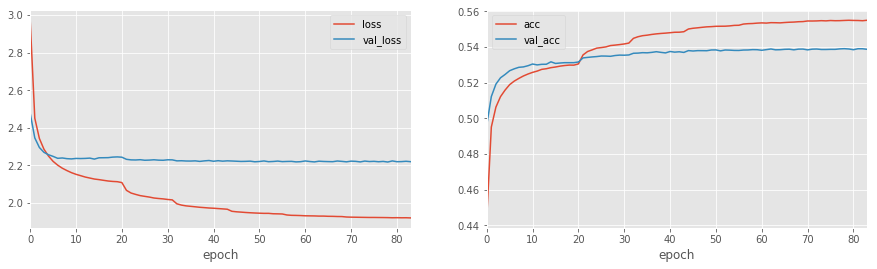

In [23]:
train_log = pd.read_csv('./pretrained/COCO/log_em512_lu512_bs64_sl1_drop_.csv')
fig, axs = plt.subplots(ncols=2, figsize=(15,4), sharex=True)
train_log.plot(x='epoch', y=['loss', 'val_loss'], ax=axs[0])
train_log.plot(x='epoch', y=['acc', 'val_acc'], ax=axs[1])

## generate captions

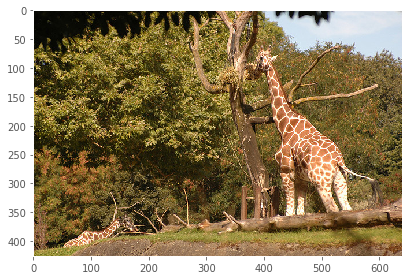

<BOS> a giraffe standing in a field with trees in the background <EOS>


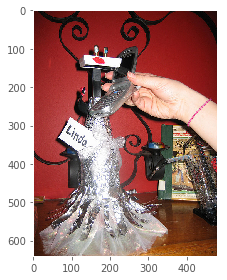

<BOS> a pair of scissors and a pair of scissors on a table <EOS>


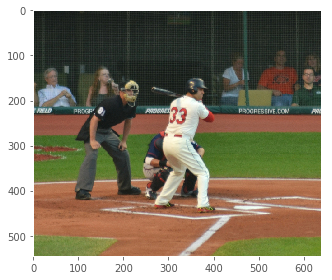

<BOS> a baseball player is swinging a bat at a ball <EOS>


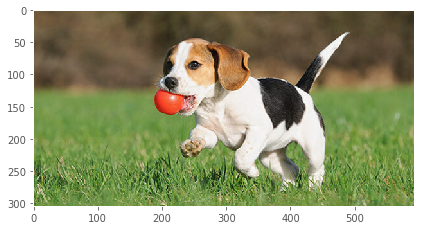

<BOS> a dog is playing with a frisbee in the grass <EOS>


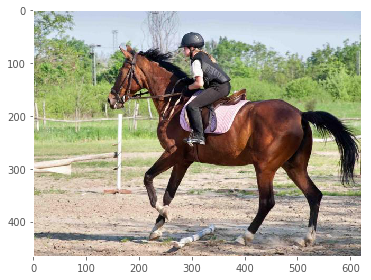

<BOS> a man riding a horse in a field <EOS>


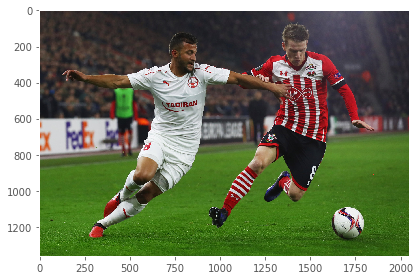

<BOS> a group of young men playing a game of soccer <EOS>


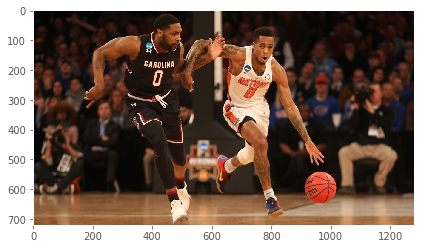

<BOS> a group of people playing a game of frisbee <EOS>


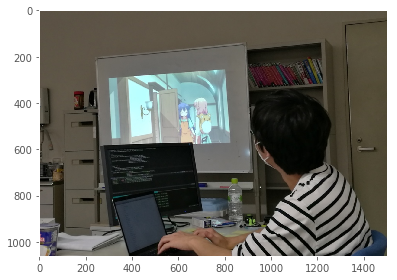

<BOS> a man sitting in front of a laptop computer <EOS>


In [27]:
from skimage.io import imread, imshow
import warnings
warnings.filterwarnings('ignore')
from generate_caps import generate_caption


img_path = ['./COCO/images/train2014/COCO_train2014_000000000025.jpg',
            './COCO/images/train2014/COCO_train2014_000000085322.jpg',
            './COCO/images/train2014/COCO_train2014_000000085211.jpg',
            'http://www.stmartinsdogkennels.com/attachments/Slider/0ab6e099-9350-26a0-6981-7e395a3967a1/23695.jpg',
            'https://static.independent.co.uk/s3fs-public/styles/article_small/public/thumbnails/image/2017/03/06/11/horse-riding-intelligence.jpg',
            'https://static01.nyt.com/images/2017/02/16/sports/16ISRAELSOCCER3/16ISRAELSOCCER3-superJumbo.jpg',
            'http://wac.b63f.edgecastcdn.net/80B63F/images/sidearm.sites/gatorzone.com/images/2017/3/26/Untitled_01_00_02_56_03_Still001.jpg',
            './images/otaku.png']

for path in img_path:
    # load image
    x = imread(path)
    plt.grid(False)
    imshow(x)
    plt.show()
    
    x = imresize(x[:, :, :3], (img_rows, img_cols), interp='bicubic')
    img_feature = deep_cnn_feature(x.reshape((1,) + x.shape))
    
    # generate caption
    candidate = generate_caption(img_feature.reshape((-1, )), im2txt_model, beam_size=1)
    for seq in candidate['seq']:
        print(' '.join(idx2word[idx] for idx in seq))